<a href="https://colab.research.google.com/github/roitraining/SparkforDataEngineers/blob/Development/Ch04_ClusterAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initialize the spark environment and load the helper functions we have provided.

In [1]:
import sys

rootpath = '/home/student/ROI/Spark/'
datapath = f'{rootpath}datasets/'
sys.path.append(rootpath)
from pyspark_helpers import *
sc, spark, conf = initspark()

import pandas as pd
import matplotlib as mp
import numpy
from matplotlib import pyplot as plt


initializing pyspark
pyspark initialized


### Read in a simple dataset of latitudes and longitudes.

In [2]:
filename = 'superchargers.csv'
df = spark.read.csv(f'{datapath}{filename}', header = True, inferSchema = True)
display(df)

# Save a pointer to the raw data
dfRawFile = df



,lat,lng
0,33.679646,-117.174095
1,28.331356,-81.532453
2,37.413353,-121.897995
3,37.525905,-122.006624
4,37.919969,-122.348976
5,38.730606,-120.788085
6,39.250765,-119.948927
7,36.916349,-121.773512
8,34.441994,-119.258898
9,36.116710,-115.168258


### Visualize this dataset using pandas. Normally you don't do this in spark but it is helpful here.

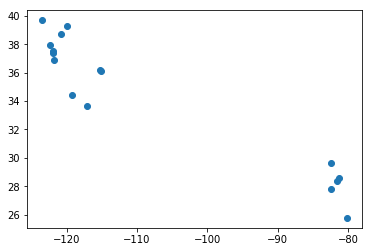

In [4]:
%matplotlib inline
p = df.toPandas()
import matplotlib.pyplot as plt
plt.plot(p.loc[:,'lng'],p.loc[:,'lat'],'o')



### Turn the features into a big vector.

In [6]:
from pyspark.ml.feature import VectorAssembler
vecAssembler = VectorAssembler(inputCols=["lat", "lng"], outputCol="features")
dfML = vecAssembler.transform(df)  # df.withColumn(calc)
display(dfML)
dfML.printSchema()
print(dfML)

,lat,lng,features
0,33.679646,-117.174095,"[33.679646, -117.174095]"
1,28.331356,-81.532453,"[28.331356, -81.532453]"
2,37.413353,-121.897995,"[37.413353, -121.897995]"
3,37.525905,-122.006624,"[37.525905, -122.006624]"
4,37.919969,-122.348976,"[37.919969, -122.348976]"
5,38.730606,-120.788085,"[38.730606, -120.788085]"
6,39.250765,-119.948927,"[39.250765, -119.948927]"
7,36.916349,-121.773512,"[36.916349, -121.773512]"
8,34.441994,-119.258898,"[34.441994, -119.258898]"
9,36.116710,-115.168258,"[36.11671, -115.168258]"


root
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- features: vector (nullable = true)

DataFrame[lat: double, lng: double, features: vector]


### Visualize the cluster results graphically.

In [13]:
params = {'seed':1, 'k': 2}
params2 = dict(seed = 1, k = 2)
print(params2)

t = (10, 20)
def fun1(k = 1, seed = 0):
    print (k, seed)
    

fun1(k = 3, seed = 5)

fun1(*t)
fun1(**params)


{'seed': 1, 'k': 2}
3 5
10 20
2 1


In [20]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

CLUSTERS = 2

#kmeans = KMeans(**params)


kmeans = KMeans(k=CLUSTERS, seed = 1)
# kmeans = KMeans().setK(CLUSTERS).setSeed(1)

# kmeans = KMeans()
# kmeans.setK(CLUSTERS)
# kmeans.setSeed(1)

dfML.persist() # dfML.cache()
model = kmeans.fit(dfML) # pandas dfML[['features']]

centroids = model.clusterCenters()
print(centroids)
print(type(centroids))
print(type(centroids[0]))

predictions = model.transform(dfML) # pandas .predict
display(predictions)



[array([ 28.0131932, -81.5283882]), array([  37.07758755, -119.92139927])]
<class 'list'>
<class 'numpy.ndarray'>


,lat,lng,features,prediction
0,33.679646,-117.174095,"[33.679646, -117.174095]",1
1,28.331356,-81.532453,"[28.331356, -81.532453]",0
2,37.413353,-121.897995,"[37.413353, -121.897995]",1
3,37.525905,-122.006624,"[37.525905, -122.006624]",1
4,37.919969,-122.348976,"[37.919969, -122.348976]",1
5,38.730606,-120.788085,"[38.730606, -120.788085]",1
6,39.250765,-119.948927,"[39.250765, -119.948927]",1
7,36.916349,-121.773512,"[36.916349, -121.773512]",1
8,34.441994,-119.258898,"[34.441994, -119.258898]",1
9,36.116710,-115.168258,"[36.11671, -115.168258]",1


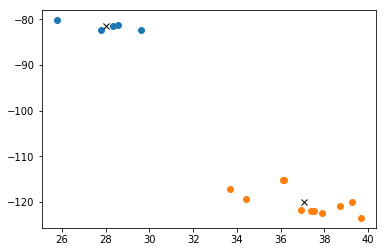

In [21]:
%matplotlib inline
for i in range(CLUSTERS):    
    #p = predictions.where(f'prediction = {i}').toPandas()[['lat','lng']]
    p = predictions.select('lat', 'lng').where(f'prediction = {i}').toPandas()
    plt.plot(p.loc[:,'lat'],p.loc[:,'lng'],'o')
    plt.plot(centroids[i][0], 
           centroids[i][1],'kx')



### Load the KMeans class and train the model. Evaluate how good it performs for several different cluster counts.

In [22]:
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator()
predictions = model.transform(dfML)
silhouette = evaluator.evaluate(predictions)
print(silhouette)

0.987806408922707


In [23]:
%matplotlib inline

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

def evaluateCluster(model, df):
    wssse = model.computeCost(dfML.select('features'))
    print("Within Set Sum of Squared Errors = " + str(wssse))

    evaluator = ClusteringEvaluator()

    predictions = model.transform(df)
    silhouette = evaluator.evaluate(predictions)
    print(f"Silhouette with squared euclidean distance = {silhouette}")

    # Shows the result.
    centers = model.clusterCenters()
    print("Cluster Centers: ")
    for center in centers:
        print(center)

for k in range(2, 5): # mean 2, 3, 4 python up to but not including 5
    print ('Number of clusters', k)
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(dfML.select('features'))
    evaluateCluster(model, dfML.select('features'))
    print()


Number of clusters 2
Within Set Sum of Squared Errors = 129.99096466421906
Silhouette with squared euclidean distance = 0.987806408922707
Cluster Centers: 
[ 28.0131932 -81.5283882]
[  37.07758755 -119.92139927]

Number of clusters 3
Within Set Sum of Squared Errors = 41.11022514378055
Silhouette with squared euclidean distance = 0.8702679015072282
Cluster Centers: 
[  38.20660229 -121.74965171]
[  35.10181175 -116.7219575 ]
[ 28.0131932 -81.5283882]

Number of clusters 4
Within Set Sum of Squared Errors = 35.03850353437156
Silhouette with squared euclidean distance = 0.7646576235092908
Cluster Centers: 
[ 28.0131932 -81.5283882]
[  37.95949117 -121.4606865 ]
[  35.10181175 -116.7219575 ]
[  39.689269 -123.483443]



### Use and elbow chart to help visualize what is the optimal number of clusters.

[129.99096466421906, 41.11022514378055, 35.03850353437156, 20.778402640553395, 18.31461362959817]


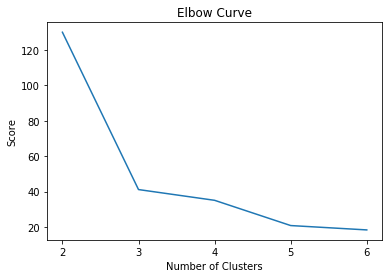

In [24]:
%matplotlib inline
def plot_elbow(df, cluster_cnt = 6):
    import numpy as np
    CLUSTERS = range(2, cluster_cnt)
    scores = [KMeans().setK(c).setSeed(1).fit(df).computeCost(df)
              for c in CLUSTERS]
    print(scores)
    plt.plot(CLUSTERS, scores)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Curve')
    plt.xticks(np.arange(2, cluster_cnt))

plot_elbow(dfML.select('features'), 7)

### Work in progress below.

In [25]:
from pyspark.ml.clustering import LDA
lda = LDA(k=10, maxIter=10)
model = lda.fit(dfML.select('features'))

# ll = model.logLikelihood(dfML)
# lp = model.logPerplexity(dfML)
# print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
# print("The upper bound on perplexity: " + str(lp))

# # Describe topics.
# topics = model.describeTopics(3)
# print("The topics described by their top-weighted terms:")
# topics.show(truncate=False)

# # Shows the result
# transformed = model.transform(dataset.select('features'))
# transformed.show()

KeyboardInterrupt: 

In [26]:
from pyspark.ml.clustering import GaussianMixture

# loads data
gmm = GaussianMixture().setK(2).setSeed(1)
model = gmm.fit(dfML)

print("Gaussians shown as a DataFrame: ")
model.gaussiansDF.show(truncate=False)

predictions2 = model.transform(dfML)
display(predictions2)

KeyboardInterrupt: 